# Partie II - Evolution temporelle

Ici, on utilise l'algorithme d'Euler explicite pour obtenir l'évolution temporelle de la fonction d'onde. Cet algorithme, bien que simple à utiliser, n'est pas très efficace.

Lors de la partie 1, on utilisait un Hamiltonien à valeurs réelles, ici nous sommes obligés d'utiliser des valeurs complexes.

Imaginons que l'on obtienne un hamiltonien complexe $\psi(x)$ sous la forme d'un array numpy

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from matplotlib.animation import PillowWriter

# On définit d'abord les constantes dx et dt.
N = 100
L = 5
dx = L/N

M = 10000
T = 10
dt = T/M
dt_approx = np.format_float_scientific(dt, precision = 1, exp_digits=1)

# Puis x tel que 

x = np.linspace(-L,L,N)

On réitère ensuite la formation d'un hamiltionien vu lors de la partie 1 pour un potentiel nul

In [102]:
V_nul = np.zeros(N) #potentiel nul

def get_matrice(potentiel):
    """
    Return d the diagonal and e the eigh-diagonal of H from a potential
    :param potentiel: potential to give
    :return: d,e diagonal and eigh-diagonal
    """

    d = np.zeros(N)
    e = np.zeros(N-1)

    for i in range(potentiel.size):
        d[i] = 2/(dx**2) + potentiel[i]

    for i in range(e.size):
        e[i] = -1/(dx**2)
        
    return d,e


def normalize(m, deltax):
    """
    Return the normalized np array, with the boundaries set to 0
    :param m: array to normalize
    :param deltax: the difference betweenn 2 x
    :return: normalized np array
    """
    m /= np.linalg.norm(m)
    m /= np.sqrt(deltax)
    m[0] = 0
    m[-1] = 0
    return m

# On crée la fonction pour former les etats stationnaires à partir de V
def get_psi_statio(potentiel):
    """
    Return (w,v) with w the eigenvalues of H and v eigenvectors
    :param potentiel: potential to find w and v
    :return: (w,v)
    """
    d,e = get_matrice(potentiel)

    ## Puis, on calcule w et v respectivement les valeurs propres et vecteurs propres de H
    w, v = eigh_tridiagonal(d,e)
    v0 = np.zeros((N,N))
    for i in range(N):
        for y in range(N):            #On échange ligne et colonnes
            v0[i][y] = v[y][i]
    # On doit désormais normaliser les vecteurs propres :
    for vec in v0:
        normalize(vec,dx)
    return w,v0

Puis, on forme la matrice H complète à partir de ses valeurs tridiagonale

In [103]:
def get_h(potentiel):
    """
    Return H the matrix from the potential
    :param potentiel: potential to get H
    :return: H matrix (N,N)
    """
    h = np.zeros((N,N),dtype=complex)
    d,e = get_matrice(potentiel)
    # on ajoute les valeurs dans H
    for i in range(N):
        h[i][i] += d[i]
        if i != N-1:
            h[i][i+1] += e[i]
            h[i+1][i] += e[i]
    return h

On forme ensuite une liste de liste psi\[t\]\[x\] représentant toutes les valeurs de v (le vecteur de psi) pour tout t

In [104]:
def f(psi,potentiel):
    """
    The method we get from the fonction of d/dt(psi)
    :param psi: psi
    :param potentiel: potential
    :return: d/dt(psi)
    """
    return np.matmul(-1j*get_h(potentiel),psi)

def euler(psi,potentiel):
    """
    The Euler method
    :param psi: psi
    :param potentiel: potential
    :return: normalized version of Euler of psi
    """
    new_psi = psi + dt*f(psi,potentiel)
    return normalize(new_psi,dx)

Enfin, on utilise la formule (7) du poly ce qui nous donne les valeurs de psi pour différents temps :

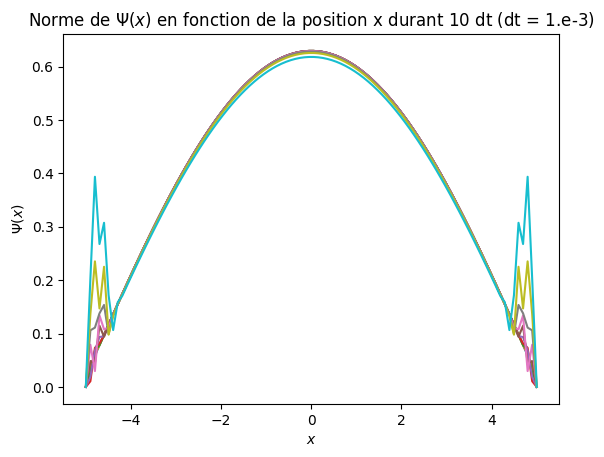

In [105]:
# On crée la fonction pour afficher les graphiques

def get_graph(psi,potentiel,method,name,nb_dt):
    """
    Return final graph, and save with number M, time nb_dt, and a chosen name
    :param psi: initial psi
    :param potentiel: potentiel of situation
    :param method: method for solbing ODE
    :param name: name to put on the graph
    :param nb_dt: number of step to show
    """
    for i in range(nb_dt):
        psi = method(psi,potentiel)
        plt.plot(x,abs(psi),label="Numérique $t=%i \cdot dt$" %i)
    plt.xlabel('$x$')
    plt.ylabel('$\Psi(x)$')
    plt.title('Norme de $\Psi(x)$ en fonction de la position x durant %i dt (dt = %s)' %(nb_dt,dt_approx))
    plt.savefig('docs/tempo/psi_fonction_de_x_%s_m%i_duree_%i.pdf' %(name,M,nb_dt),format='pdf')
    plt.savefig('docs/tempo/psi_fonction_de_x_%s_m%i_duree_%i.jpeg' %(name,M,nb_dt),format='jpeg')
    plt.show()

w_test,v_test = get_psi_statio(V_nul)
psi0 = v_test[0] #Première harmonique
get_graph(psi0,V_nul,euler,"euler_etat_statio0",10)

Ici, nous allons reprendre le même processus mais avec un état initial sous forme d'un paquet d'onde d'une gaussienne

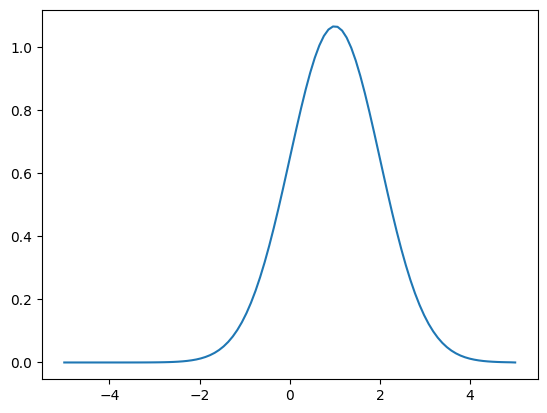

In [106]:
def get_psi_gauss(x0,sigma):
    """
    Get the Psi0 in a form of a gaussian wave paquet
    :param x0: X where the gaussian is maximal
    :param sigma: how large is the gaussian
    :return: psi0
    """
    psi = np.zeros(N,dtype=complex)

    for i in range(N):
        inside_exp = -((x[i]-x0)**2)/(2*(sigma**2))
        psi[i] = np.exp(inside_exp)/(sigma*np.sqrt(2*np.pi))

    psi = normalize(psi,dx)
    return psi

psi0 = get_psi_gauss(1,1)
plt.plot(x,np.abs(psi0))
plt.show()

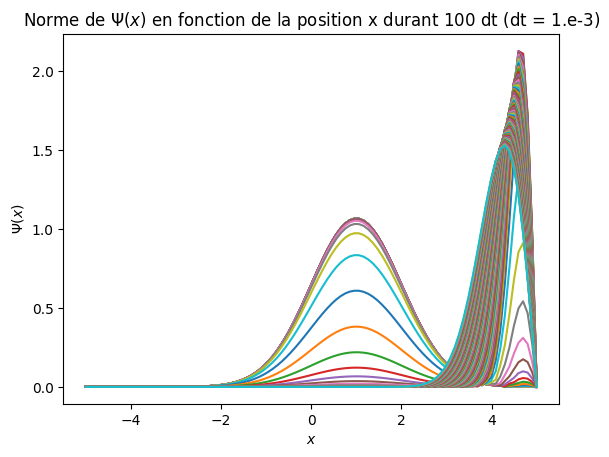

In [107]:
get_graph(psi0,V_nul,euler,"euler_gaussienne",100)

On remarque ici que notre rendu n'est pas correct, ou alors est trop long. En effet l'algorithme d'Euler explicite ne nous permet pas d'être suffisament précis, nous allons donc mettre en oeuvre l'algorithme de Runge-Kutta d'ordre 4

In [108]:
def rk4(psi,potentiel):
    """
    RK4 method
    :param psi: psi
    :param potentiel: potential
    :return: rk4 of psi
    """
    k1 = f(psi,potentiel)
    k2 = f(psi + k1 * dt / 2.,potentiel)
    k3 = f(psi + k2 * dt / 2.,potentiel)
    k4 = f(psi + k3 * dt,potentiel)
    new_psi = psi + (dt / 6.)*(k1 + 2*k2 + 2*k3 + k4)
    return normalize(new_psi,dx)

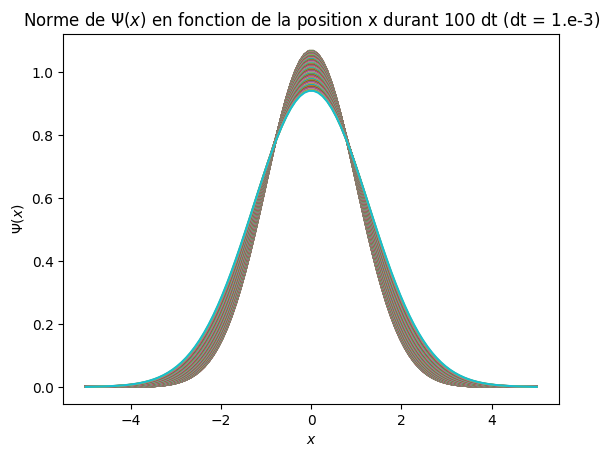

In [109]:
get_graph(get_psi_gauss(0,1),V_nul,rk4,"rk4_gaussienne",100)

In [110]:
# ------------ ANIMATION -------------- #
def get_anim_diff_between_methods(psi_init_1,psi_init_2,potentiel,step,name):
    """
    Save a gif named anim_RK4 with a specific name that compare euler and RK4
    :param psi_init_1: Initial psi for RK4
    :param psi_init_2: Initial psi for Euler
    :param potentiel: Total potential
    :param step: save a image each [step] itérations
    :param name: name to add to the file
    """

    metadata = dict(title='test', artist='lucas')
    writer = PillowWriter(fps=60, metadata=metadata)

    fig = plt.figure()
    plt.xlim(-L, L)
    plt.ylim(0, 1.5)

    t = 0
    t_approx = np.format_float_scientific(t, precision = 2, exp_digits=1)

    plt.xlabel('$x$')
    plt.ylabel('$\\Psi(x)$')
    plt.title('Norme de $\\Psi(x)$ en fonction de la position x (t = %s)' % t_approx)

    l, = plt.plot(x,abs(psi_init_1),label="RK4")
    l2, = plt.plot(x,abs(psi_init_2), label="Euler")

    plt.legend()

    new_psi1 = psi_init_1
    new_psi2 = psi_init_2

    with writer.saving(fig, "docs/tempo/anim_%s.gif"%name, 100):
        for i in range(0,M):
            new_psi1 = rk4(new_psi1,potentiel)
            new_psi2 = euler(new_psi2,potentiel)

            t += dt

            if i%step == 0:

                l.set_data(x,abs(new_psi1))
                l2.set_data(x,abs(new_psi2))

                t_approx = np.format_float_scientific(t, precision = 2, exp_digits=1)
                plt.title('Norme de $\\Psi(x)$ en fonction de la position x (t = %s) pour un dt=%s' % (t_approx,dt_approx))

                writer.grab_frame()
    plt.show()
# ------------ FIN ANIMATION -------------- #

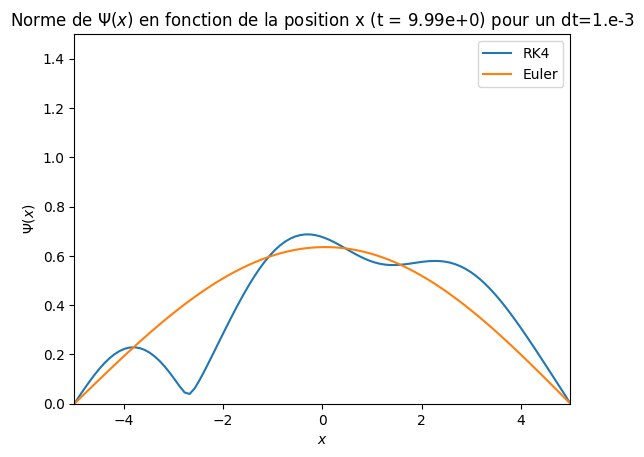

In [111]:
get_anim_diff_between_methods(get_psi_gauss(1,1),get_psi_gauss(-1,1),V_nul,10,"gauss_pot_nul_séparé")

### Sources :
 - https://www.f-legrand.fr/scidoc/docmml/numerique/euler/euler/euler.html
 - https://www.youtube.com/watch?v=tsK72kSgPoI
 - https://www.moonbooks.org/Articles/How-to-create-a-matrix-of-complex-numbers-in-python-using-numpy-/
 - https://femto-physique.fr/analyse-numerique/runge-kutta.php